In [89]:
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets
import torchvision.transforms as transforms
from torch import optim
import torch
from matplotlib import pyplot as plt

In [90]:
import tensorflow as tf

In [91]:
if torch.cuda.is_available():
    device=torch.device(type='cuda',index=0)
else:
    device=torch.device(type='cpu',index=0)

In [92]:
train_data=datasets.MNIST(root='/kaggle/temp/mnist_train', train=True, download=True, transform=transforms.Compose([transforms.Resize(32), transforms.ToTensor(),transforms.Normalize([0.5],[0.5])]))

In [93]:
batch_size=64

In [94]:
train_dataloader=DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True)

In [95]:
def convblock(in_channels, out_channels, kernel_size=4, stride=2, padding=1):
    layers=[nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)]
    layers.append(nn.BatchNorm2d(num_features=out_channels))
    layers.append(nn.LeakyReLU(0.1))
    return nn.Sequential(*layers)
def transconvblock(in_channels, out_channels, kernel_size=4, stride=2, padding=1):
    layers=[nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride, padding)]
    layers.append(nn.BatchNorm2d(num_features=out_channels))
    layers.append(nn.ReLU())
    return nn.Sequential(*layers)

In [139]:
class Gene(nn.Module):
    def __init__(self, latent, img_size):
        super().__init__()
        self.latent=latent
        self.img_size=img_size
        self.ltoc=nn.Linear(in_features=self.latent, out_features= 128*(self.img_size//4)*(self.img_size//4))
        self.tconv=nn.Sequential(transconvblock(128,64,4,2,1), transconvblock(64, 32, 4, 2, 1))
        self.lasttconvlayer=nn.ConvTranspose2d(in_channels=32, out_channels=1,stride=1, kernel_size=3, padding=1)
    def forward(self, x):
        x=self.ltoc(x)
        x=x.view(x.shape[0], 128, (self.img_size//4), (self.img_size//4))
        x=self.tconv(x)
        x=self.lasttconvlayer(x)
        return x
class Disc(nn.Module):
    def __init__(self, img_size):
        super().__init__()
        self.img_size=img_size
        self.convlayers=nn.Sequential(convblock(1, 16, 4, 2, 1), convblock(16, 32, 4, 2, 1), convblock(32, 64, 4, 2, 1), convblock(64, 128, 4, 2, 1))
        self.out=nn.Sequential(nn.Linear(128*4, 2))
    def forward(self, x):
        x=self.convlayers(x)
#         print(x.shape)
        x = x.view(x.shape[0], 128*4)
#         print(x.shape)
        pred=self.out(x)
        return pred        

In [140]:
loss_fn=nn.CrossEntropyLoss()
# n_epochs=5
# lr=0.0002
generator=Gene(100, 32)
discriminator=Disc(32)
# gopt=optim.Adam(params=generator.parameters(),lr=lr)
# dopt=optim.Adam(params=discriminator.parameters(),lr=lr)

In [141]:
noise_vectors=torch.randn((32,100))
x=generator(noise_vectors)
print(x.shape)
x=discriminator(x)
print(x.shape)


torch.Size([32, 1, 32, 32])
torch.Size([32, 2])


In [145]:
import torch

def train(plt):
    torch.autograd.set_detect_anomaly(True)  # Enable anomaly detection

    for i, (imgs, _) in enumerate(train_dataloader):
        noise_vectors = torch.randn((imgs.shape[0], 100))
        zero_labels = torch.zeros((imgs.shape[0])).type(torch.int64)
        one_labels = torch.ones((imgs.shape[0])).type(torch.int64)
#         print(zero_labels.shape)
#         print(one_labels.shape)

        fake_images = generator(noise_vectors)
        pred = discriminator(fake_images)
        g_loss = loss_fn(pred, one_labels)
        
        goptim.zero_grad()
#         generator.requires_grad_(True)
#         discriminator.requires_grad_(False)
        g_loss.backward(retain_graph=True)
        goptim.step()

        pred_on_real = discriminator(imgs)
        dloss_on_real = loss_fn(pred_on_real, one_labels)
        pred_on_fake = discriminator(fake_images.detach())  # Detach fake_images to avoid backpropagating through generator
        dloss_on_fake = loss_fn(pred_on_fake, zero_labels)
        dloss = (dloss_on_real + dloss_on_fake) / 2

        doptim.zero_grad()
#         generator.requires_grad_(False)
#         discriminator.requires_grad_(True)
        dloss.backward()
        doptim.step()

        if i % 500 == 0:
            print("Batch No.:", i + 1, "/", len(train_dataloader), "GLoss=", round(g_loss.item(), 4), "DLoss=", round(dloss.item(), 4))
            for j in range(64):
                plt.subplot(8, 8, j + 1)
                plt.imshow(torch.permute(fake_images[j], (1, 2, 0)).detach().cpu(), interpolation='nearest', cmap='gray_r')

            plt.show()


In [146]:
loss_fn=nn.CrossEntropyLoss()
n_epochs=10
lr=0.0002

generator=Gene(100,32)
discriminator=Disc(32)

goptim=optim.Adam(params=generator.parameters(),lr=lr)
doptim=optim.Adam(params=discriminator.parameters(),lr=lr)

Epoch 1 / 10 :
Batch No.: 1 / 938 GLoss= 0.7307 DLoss= 0.6539


/tmp/ipykernel_34/1568899455.py:38: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(8, 8, j + 1)


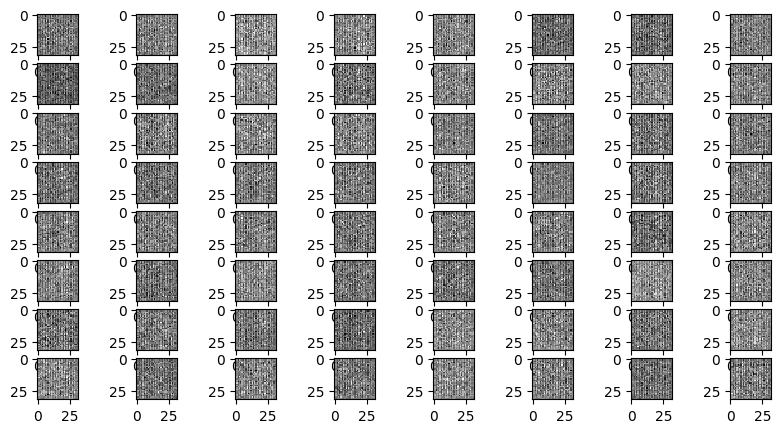

Batch No.: 501 / 938 GLoss= 7.3125 DLoss= 0.0073


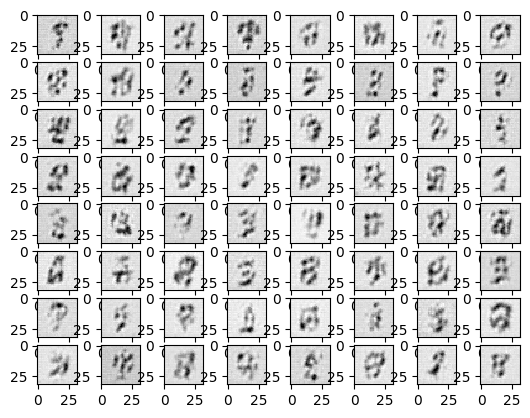

Epoch 2 / 10 :
Batch No.: 1 / 938 GLoss= 8.2485 DLoss= 0.0081


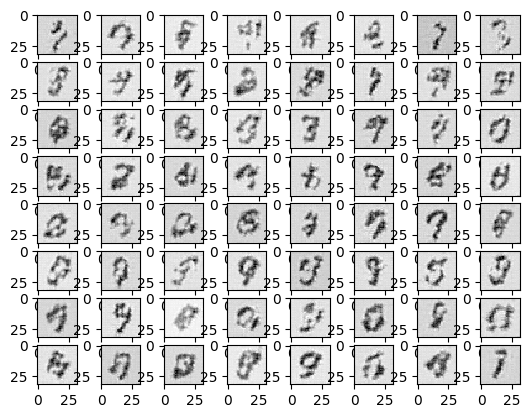

Batch No.: 501 / 938 GLoss= 3.4003 DLoss= 0.0368


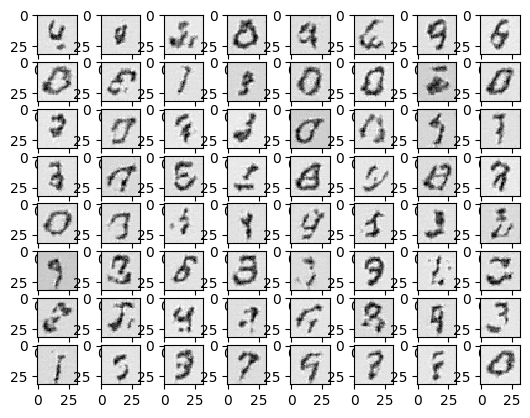

Epoch 3 / 10 :
Batch No.: 1 / 938 GLoss= 5.9559 DLoss= 0.0042


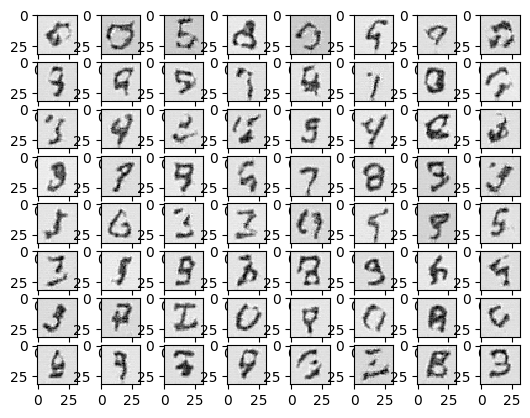

Batch No.: 501 / 938 GLoss= 5.3205 DLoss= 0.0047


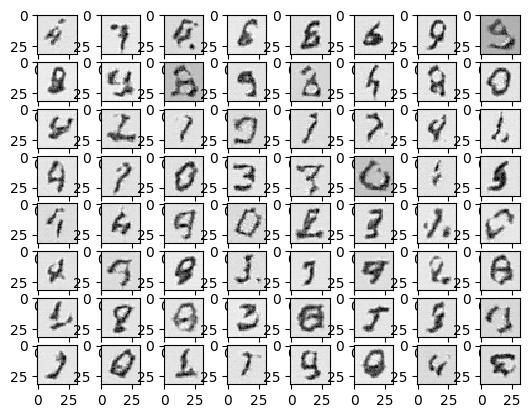

Epoch 4 / 10 :
Batch No.: 1 / 938 GLoss= 3.5161 DLoss= 0.0304


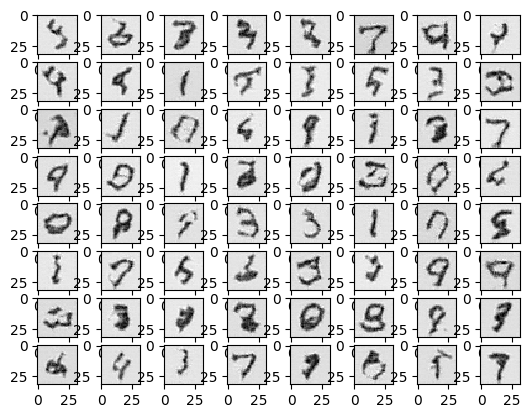

Batch No.: 501 / 938 GLoss= 3.5713 DLoss= 0.0406


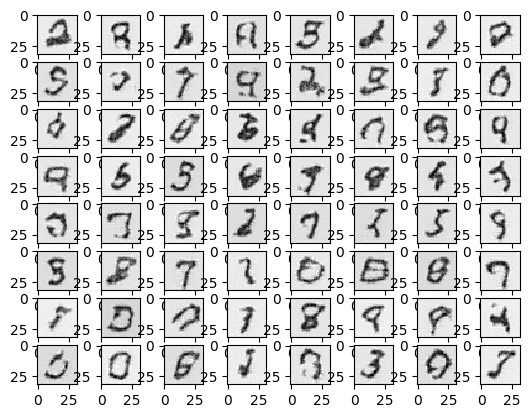

Epoch 5 / 10 :
Batch No.: 1 / 938 GLoss= 6.9914 DLoss= 0.0027


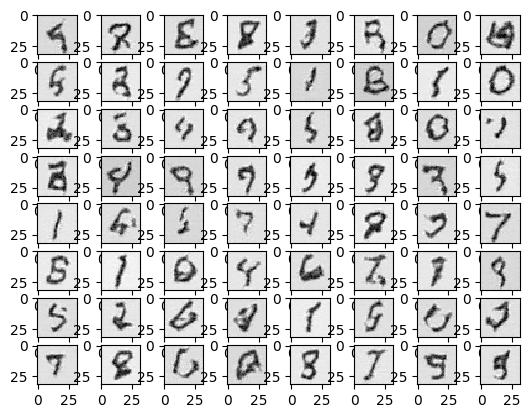

Batch No.: 501 / 938 GLoss= 4.8783 DLoss= 0.0086


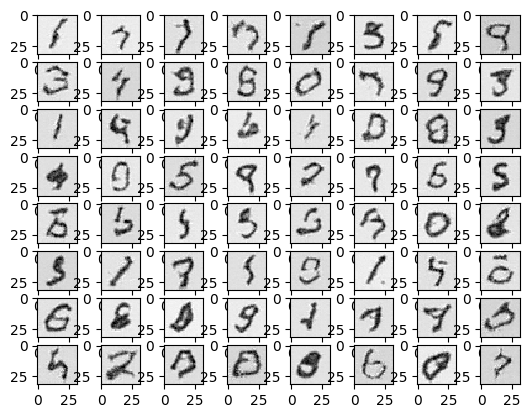

Epoch 6 / 10 :
Batch No.: 1 / 938 GLoss= 8.2231 DLoss= 0.1053


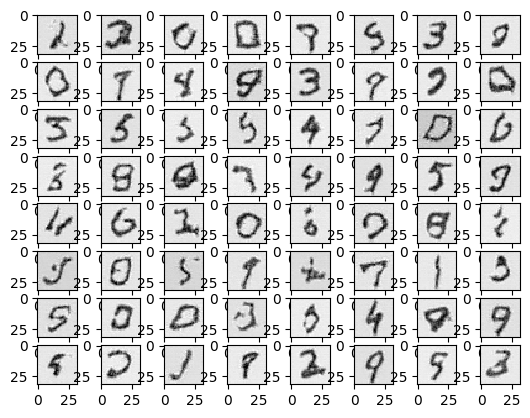

Batch No.: 501 / 938 GLoss= 5.391 DLoss= 0.0048


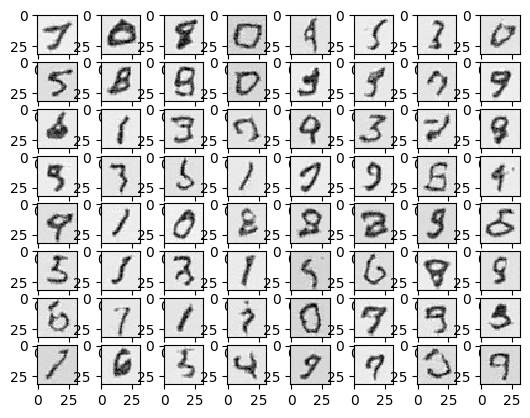

Epoch 7 / 10 :
Batch No.: 1 / 938 GLoss= 7.7346 DLoss= 0.002


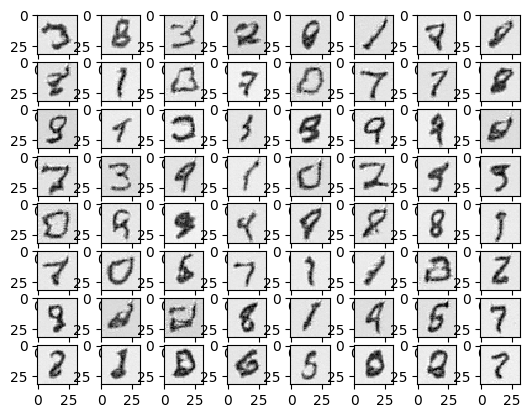

Batch No.: 501 / 938 GLoss= 2.1256 DLoss= 0.1057


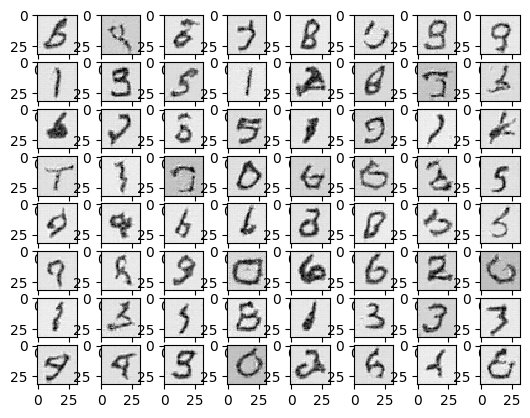

Epoch 8 / 10 :
Batch No.: 1 / 938 GLoss= 6.6534 DLoss= 0.0025


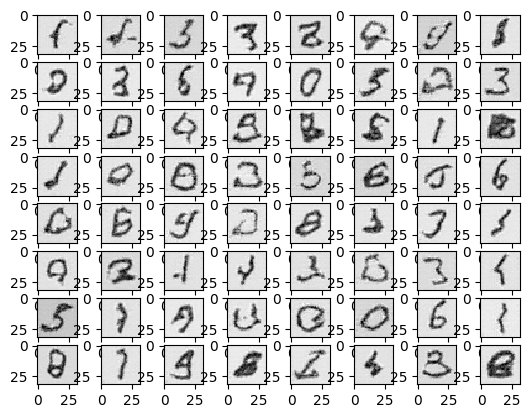

Batch No.: 501 / 938 GLoss= 7.3062 DLoss= 0.0175


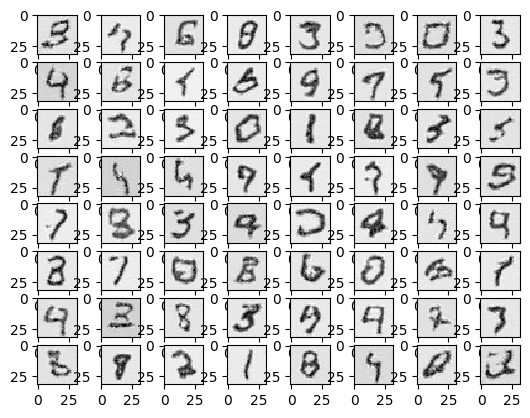

In [ ]:
plt.figure(figsize=(10,5))
plt.title("Generated Images")
for e in range(n_epochs):
    print("Epoch",e+1,"/",n_epochs,":")
    train(plt)